In [52]:
import os
os.chdir("..")
import relegy.embeddings as rle
import relegy.metrics as rlm
os.chdir("Analysis")

In [9]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import inspect
from IPython.display import clear_output
from matplotlib.pylab import rcParams
import sys

In [10]:
def get_embedding_methods_iterable():
    return filter(lambda x: x[0][:2] != "__", inspect.getmembers(sys.modules['relegy.embeddings']))

In [11]:
def generate_clusters_graph(n, k, p):
    partition = np.random.multinomial(n, np.ones(k)/k, size=1)[0]
    labels = np.repeat(np.arange(k), partition)
    G = nx.Graph()
    cur_min = 0
    for i in partition:
        ng = nx.complete_graph(range(cur_min, cur_min+i))
        G.add_nodes_from(ng)
        G.add_edges_from(ng.edges)
        cur_min += i
#     perm = np.random.permutation(G.nodes)
#     labs = dict(enumerate(perm))
#     G = nx.relabel_nodes(G, labs)
    G1 = nx.complement(G)
    arr = np.arange(len(G1.edges))
    new_edges_size = np.floor(p*len(arr))
    new_edges = np.random.choice(arr, size=new_edges_size.astype(int))
    G.add_edges_from(np.array(G1.edges)[new_edges,:])
    return G, labels

In [12]:
G, labels = generate_clusters_graph(100, 7, 0.03)

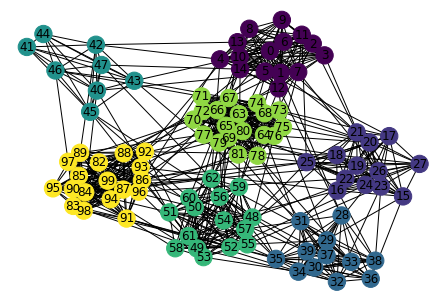

In [13]:
nx.draw(G, with_labels=True, node_color=labels)

# LaplacianEigenmaps fast_embed

In [14]:
Z_le = rle.LaplacianEigenmaps.fast_embed(G, num_iter=300, d=5)

Iteration limit reached    (Exit mode 9)
            Current function value: [0.04865742]
            Iterations: 300
            Function evaluations: 2615
            Gradient evaluations: 300


In [15]:
Z_scaled = StandardScaler().fit_transform(Z_le)
Z_le_pca = PCA(n_components=2).fit_transform(Z_scaled)

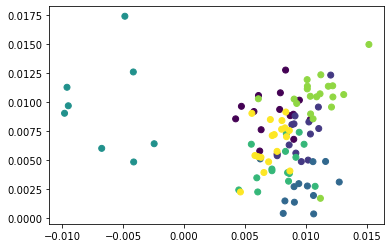

In [16]:
plt.scatter(Z_le[:, 0], Z_le[:, 1], c=labels)

# GraphFactorization

In [17]:
gf = rle.GraphFactorization(G)

gf.initialize(d = 2)
gf.initialize_model(lr=0.01)
gf.fit(num_iter = 300)
Z_gf = gf.embed()

Epoch 1: 825.9137
Epoch 2: 820.3962
Epoch 3: 813.11804
Epoch 4: 804.0143
Epoch 5: 793.02844
Epoch 6: 780.102
Epoch 7: 765.1814
Epoch 8: 748.2301
Epoch 9: 729.2353
Epoch 10: 708.20636
Epoch 11: 685.17365
Epoch 12: 660.1891
Epoch 13: 633.327
Epoch 14: 604.68744
Epoch 15: 574.3972
Epoch 16: 542.61365
Epoch 17: 509.5258
Epoch 18: 475.3572
Epoch 19: 440.36694
Epoch 20: 404.85065
Epoch 21: 369.1402
Epoch 22: 333.60278
Epoch 23: 298.63785
Epoch 24: 264.672
Epoch 25: 232.15196
Epoch 26: 201.53297
Epoch 27: 173.26323
Epoch 28: 147.76259
Epoch 29: 125.39518
Epoch 30: 106.436584
Epoch 31: 91.03815
Epoch 32: 79.19344
Epoch 33: 70.71441
Epoch 34: 65.22544
Epoch 35: 62.182278
Epoch 36: 60.91679
Epoch 37: 60.703484
Epoch 38: 60.836918
Epoch 39: 60.706013
Epoch 40: 59.85164
Epoch 41: 57.998306
Epoch 42: 55.057102
Epoch 43: 51.103813
Epoch 44: 46.34005
Epoch 45: 41.04645
Epoch 46: 35.536095
Epoch 47: 30.113857
Epoch 48: 25.045258
Epoch 49: 20.535988
Epoch 50: 16.721994
Epoch 51: 13.668591
Epoch 52: 11.

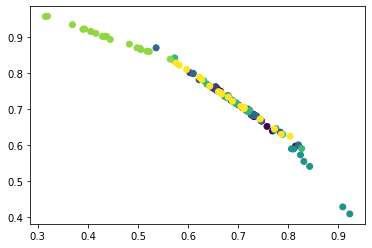

In [18]:
plt.scatter(Z_gf[:, 0], Z_gf[:, 1], c=labels)

In [19]:
obtained_matrix = Z_gf @ Z_gf.T

In [20]:
rmse = rlm.rmse(nx.to_numpy_array(G, nodelist=G.nodes), obtained_matrix)

patk = rlm.precision_at_k(nx.to_numpy_array(G, nodelist=G.nodes), obtained_matrix)

In [21]:
print(rmse)

0.8904971026331567


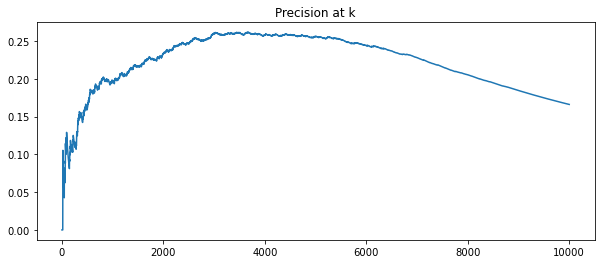

In [22]:
rcParams["figure.figsize"] = 10, 4
plt.plot(patk)
plt.title("Precision at k")
plt.show()

In [26]:
gf.fit(10)

Epoch 1: 5.108598
Epoch 2: 5.108042
Epoch 3: 5.10749
Epoch 4: 5.106941
Epoch 5: 5.1063976
Epoch 6: 5.1058564
Epoch 7: 5.105319
Epoch 8: 5.104786
Epoch 9: 5.1042566
Epoch 10: 5.103731


In [53]:
results_dictionary = {}
for name, class_handle in get_embedding_methods_iterable():
    if not (name == "GCN" or name == "GNN"):
        print("Currently processing " + str(name))
        results_dictionary[name] = class_handle.fast_embed(G, d=2)
        clear_output()

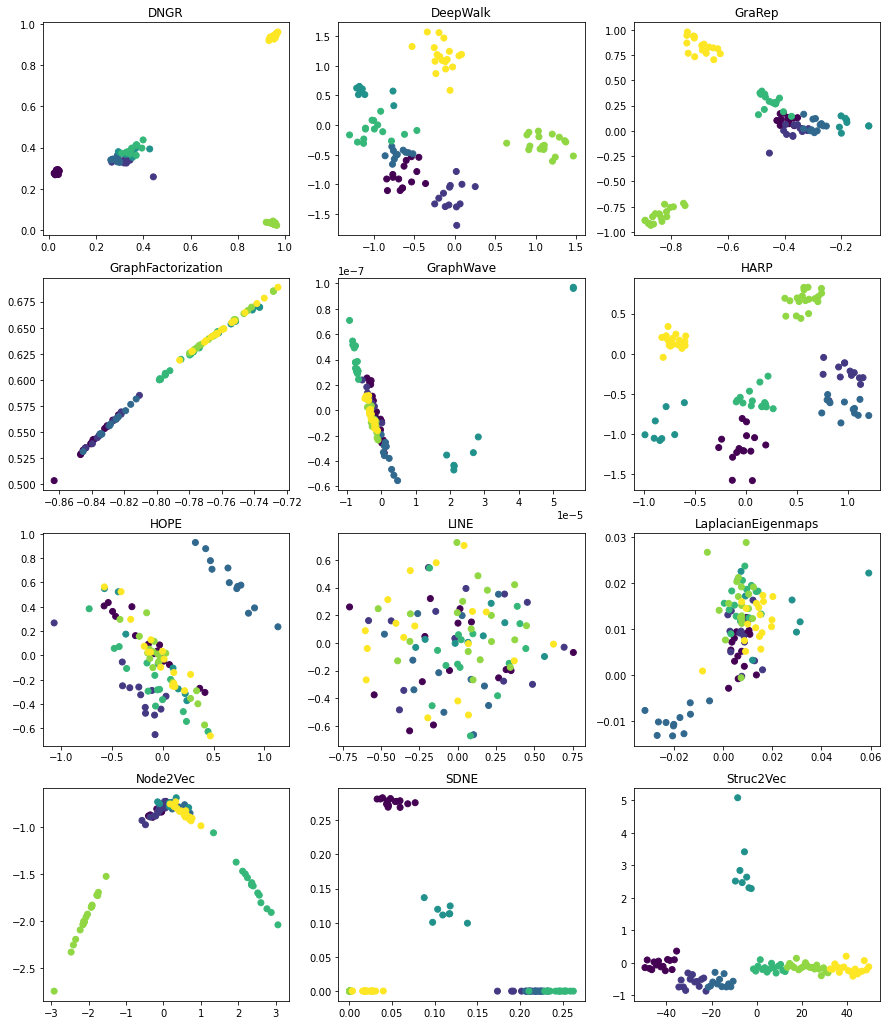

In [54]:
rcParams["figure.figsize"] = 15, 18
fig, axs = plt.subplots(4, 3)
names = list(results_dictionary.keys())
for i in range(len(names)):
    ix_x = i // 3
    ix_y = i % 3
    cur_Z = results_dictionary[names[i]]
    if cur_Z.shape[1] != 2:
        ss = StandardScaler().fit_transform(cur_Z)
        pca_Z = PCA(n_components=2).fit_transform(cur_Z)
        cur_Z = pca_Z
    axs[ix_x, ix_y].scatter(cur_Z[:, 0], cur_Z[:, 1], c=labels)
    axs[ix_x, ix_y].set_title(names[i])

In [55]:
results_dictionary = {}
for name, class_handle in get_embedding_methods_iterable():
    if not (name == "GCN" or name == "GNN"):
        print("Currently processing " + str(name))
        results_dictionary[name] = class_handle.fast_embed(G, d=5)
        clear_output()

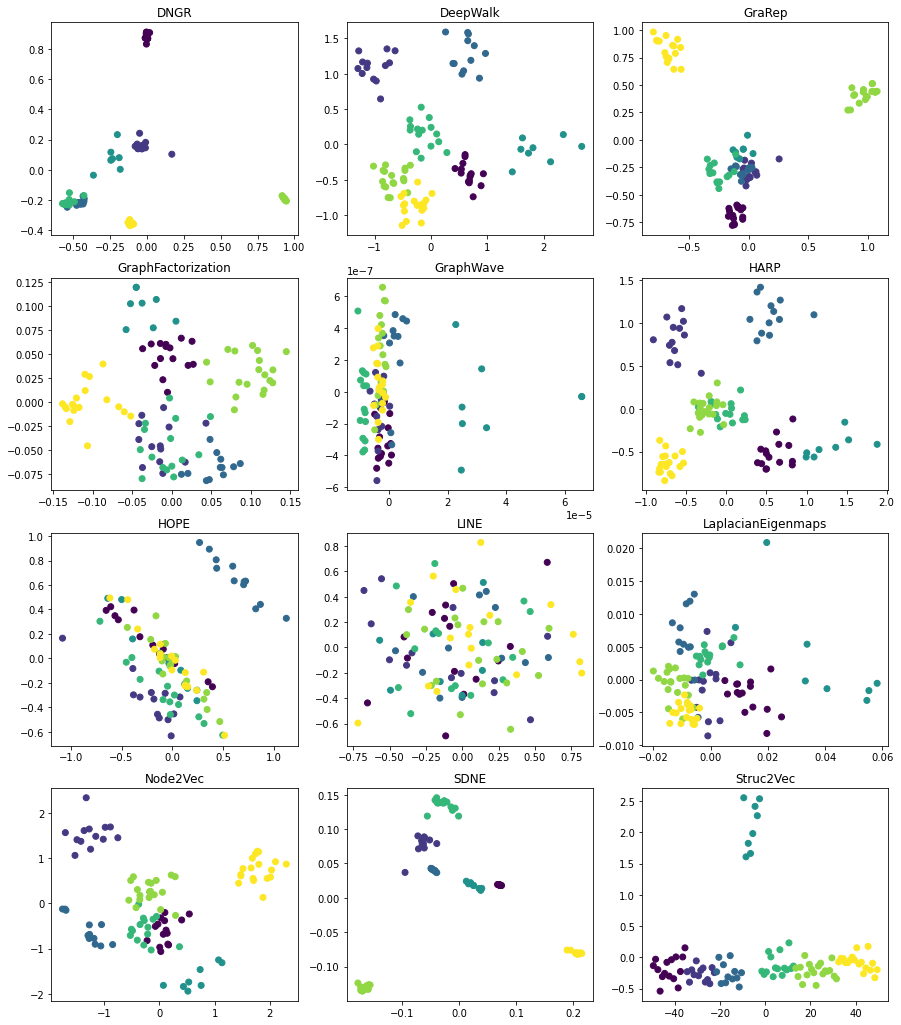

In [56]:
rcParams["figure.figsize"] = 15, 18
fig, axs = plt.subplots(4, 3)
names = list(results_dictionary.keys())
for i in range(len(names)):
    ix_x = i // 3
    ix_y = i % 3
    cur_Z = results_dictionary[names[i]]
    if cur_Z.shape[1] != 2:
        ss = StandardScaler().fit_transform(cur_Z)
        pca_Z = PCA(n_components=2).fit_transform(cur_Z)
        cur_Z = pca_Z
    axs[ix_x, ix_y].scatter(cur_Z[:, 0], cur_Z[:, 1], c=labels)
    axs[ix_x, ix_y].set_title(names[i])